# M vs. ME predictions

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
from Bio import SeqIO
import re
import coralme
plt.rcParams['svg.fonttype'] = 'none'
pandas.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2

## Naive model

In [2]:
model = coralme.io.pickle.load_pickle_me_model("./pputidame/MEModel-step3-pputida-Keff.pkl")

In [3]:
medium = pandas.read_csv("./media/M9.txt",index_col="ID",comment="#")["Bound"]
def enforce_medium(model,medium):
    for r in model.reactions.query("^EX_"):
        r.lower_bound = 0
    for r,lb in medium.items():
        model.reactions.get_by_id(r).lower_bound = lb

### M9

In [4]:
enforce_medium(model,medium)

In [5]:
model.optimize(max_mu=1.0)

Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	0.5000000000000000	Not feasible
        2	0.2500000000000000	Optimal
        3	0.3750000000000000	Optimal
        4	0.4375000000000000	Not feasible
        5	0.4062500000000000	Optimal
        6	0.4218750000000000	Optimal
        7	0.4296875000000000	Not feasible
        8	0.4257812500000000	Optimal
        9	0.4277343750000000	Not feasible
       10	0.4267578125000000	Not feasible
       11	0.4262695312500000	Not feasible
       12	0.4260253906250000	Not feasible
       13	0.4259033203125000	Optimal
       14	0.4259643554687500	Not feasible
       15	0.4259338378906250	Not feasible
       16	0.4259185791015625	Optimal
       17	0.4259262084960938	Optimal
       18	0.4259300231933594	Optimal
       19	0.4259319305419922	Optimal
       20	0.4259328842163086	Optimal


True

In [8]:
from coralme.util.flux_analysis import exchange_single_model,flux_based_reactions

In [9]:
model.solution.to_frame().to_csv("./datasets/predictions/KT2440-UPF36-M9.csv")

## M-model

In [10]:
import cobra
gem = cobra.io.load_json_model("./pputidame/inputs/m_model.json")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-03


### M9

In [11]:
enforce_medium(gem,medium)

In [12]:
gem.optimize().to_frame().to_csv("./datasets/predictions/KT2440-MMODEL-M9.csv")

# Comparison

In [13]:
gem.solution = gem.optimize()

In [14]:
MetabolicFluxes = pandas.concat([gem.solution.to_frame()[["fluxes"]].rename(columns={"fluxes":"m"}),
               pandas.Series(model.get_metabolic_flux()).to_frame().rename(columns={0:"me"})],axis=1)

Building reaction dictionary...                                            : 100.0%|██████████|  2563/ 2563 [00:00<00:00]
Processing ME-model Reactions...                                           : 100.0%|██████████| 14418/14418 [00:00<00:00]


/opt/miniconda3/envs/coralme-1.1.5/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/opt/miniconda3/envs/coralme-1.1.5/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


<Axes: xlabel='m', ylabel='me'>

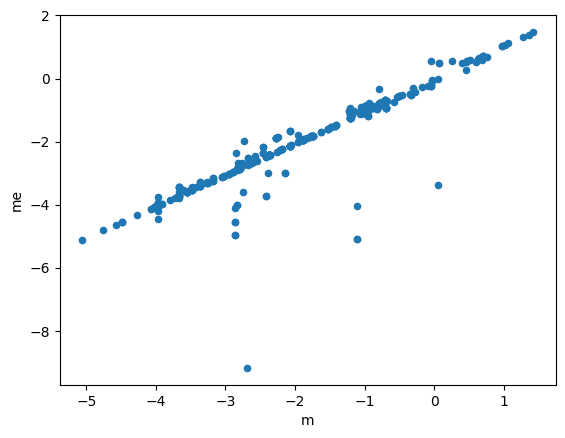

In [15]:
numpy.log10(MetabolicFluxes.dropna()).plot.scatter(x="m",y="me")

### Save simulation conditions

In [16]:
def save_dict_of_dataframes_to_excel(dict_of_dataframes, excel_filename):
    """
    Save a dictionary of dataframes into an Excel worksheet, with each dataframe in a separate sheet.

    Parameters:
    - dict_of_dataframes (dict): A dictionary where keys are sheet names and values are dataframes.
    - excel_filename (str): The name of the Excel file to be created.

    Example:
    ```python
    dataframes_dict = {'Sheet1': df1, 'Sheet2': df2, 'Sheet3': df3}
    save_dict_of_dataframes_to_excel(dataframes_dict, 'output.xlsx')
    ```
    """
    with pandas.ExcelWriter(excel_filename, engine='xlsxwriter') as writer:
        for sheet_name, dataframe in dict_of_dataframes.items():
            dataframe.to_excel(writer, sheet_name=sheet_name, index=True)


In [17]:
dct = {
    "Constraints" : pandas.Series({r.id:r.lower_bound for r in model.reactions.query("^EX_") if r.lower_bound<0}),
    "ME-model simulations" : pandas.read_csv("./datasets/predictions/KT2440-UPF36-M9.csv",index_col=0),
    "M-model simulations" : pandas.read_csv("./datasets/predictions/KT2440-MMODEL-M9.csv",index_col=0),
}

In [18]:
save_dict_of_dataframes_to_excel(dct,"./datasets/supplementary/SupplementaryTable2.xlsx")